In [1]:
%run nbloader.py
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import math
import numpy as np


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from read_opera_bg import load_bg

importing notebook from read_opera_bg.ipynb
bg: 2767 tracks
len(slopes): 2767


In [3]:
from read_opera_mc import load_mc

importing notebook from read_opera_mc.ipynb
numtracks reduction by cuts:  [188, 186, 109, 50, 19, 19]
len(slopes): 731


In [4]:
pbg = load_bg(step=50)

bg: 546462 tracks


In [5]:
pmc = load_mc(step=1)

numtracks reduction by cuts:  [18724, 18678, 11058, 5389, 2799, 2684]


In [7]:
def feature_creator(dmix, pmc, id):
    dZ = 204
    electron = pmc.iloc[id][['ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy']]
    
    xb_2 = dZ * dmix['b_sx']
    yb_2 = dZ * dmix['b_sy']
    zb_2 = dZ
    
    xe = dZ * electron['ele_sx']
    ye = dZ * electron['ele_sy']
    ze = dZ
    
    dmix['alpha_2'] = (xb_2 * xe + yb_2 * ye + zb_2 * ze)/(((xb_2**2 + yb_2**2 + zb_2**2)**0.5) * ((xe**2 + ye**2 + ze**2)**0.5))
    dmix['alpha_2'] = dmix.apply(lambda x: math.acos(x['alpha_2']), axis=1)
    
    #xp = dmix['b_x']  - zb * dmix['b_sx'] 
    #yp = dmix['b_y']  - zb * dmix['b_sy'] 
    #dmix['IP'] = ((electron['ele_sx'] - xp)**2 + (electron['ele_sy'] - yp)**2)**0.5 / zb
    
    zb = dmix['b_z'] - electron['ele_z']
    xp = dmix['b_x']  + dZ * dmix['b_sx'] 
    yp = dmix['b_y']  + dZ * dmix['b_sy']
    zp = dmix['b_z'] + dZ
    
    el = np.array(electron[0:3], dtype = float)
    IP_0 = np.array([xp, yp, zp], dtype = float)
    IP_1 = np.array([dmix['b_x'], dmix['b_y'], dmix['b_z']], dtype = float)
    length = len(xp)
    IP = []
    
    for i in range(length):
        IP.append(np.linalg.norm(np.cross(el - IP_0[:,i], el - IP_1[:,i]))/np.linalg.norm(IP_0[:,i] - IP_1[:,i]))
    
    dmix['IP'] = IP
    dmix['IP'] = dmix['IP']/zb
     
    
    dmix['d_sx'] = electron['ele_sx'] - dmix['b_sx']
    dmix['d_sy'] = electron['ele_sy'] - dmix['b_sy']
    dmix['zb'] = dmix['b_z'] - electron['ele_z']
                               
    return dmix
                               
                               

In [8]:
def alpha_creator(dmix, pmc, id):
    dZ = 204
    electron = pmc.iloc[id][['ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy']]
    xb = dmix['b_x'] - electron['ele_x']
    yb = dmix['b_y'] - electron['ele_y']
    zb = dmix['b_z'] - electron['ele_z']
    
    xe = dZ * electron['ele_sx']
    ye = dZ * electron['ele_sy']
    ze = dZ
    
    
    dmix['alpha'] = (xb * xe + yb * ye + zb * ze)/(((xb**2 + yb**2 + zb**2)**0.5) * ((xe**2 + ye**2 + ze**2)**0.5))
    dmix['alpha'] = dmix.apply(lambda x: math.acos(x['alpha']), axis=1)
    
    return dmix

In [9]:
def combine_mc_bg(pmc, pbg, cone_angle = 0.05, begin = 0, end = 50):
    dZ = 204
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY']],
                index=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy']).T
    dmix['signal'] = 0
    final_data = pd.DataFrame().T

    for i in range(begin ,end):
        df = pmc.iloc[i]
        d0 = pd.DataFrame([
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'] - df['BT_Z'] % 1293,
                df['BT_SX'],
                df['BT_SY']],
                index=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy']).T
        d0['signal'] = 1
        
    
        data = pd.concat([dmix, d0]) #pd.concat([dmix[i::a], d0])
        data['event'] = df['Event_id']
        data = alpha_creator(data, pmc, i) # change pmc with electron to save time
        data = data.loc[data['alpha'] < cone_angle]  #save data only inside cone
        if len(data.loc[data['signal'] == 0]['b_x']) != 0: #if there isn't any noise on 
                                                           #the way of shower - delete                                                # make sense?
            data = feature_creator(data, pmc, i) #create fetures only for useful events
            final_data = pd.concat([data, final_data])
        
    
    return final_data

In [14]:
dmix = combine_mc_bg(pmc, pbg, 0.05, 0, 1)

In [33]:
features = list(set(dmix.columns) - {'event', 'signal', 'b_x', 'b_y', 'b_z', 'b_sx', 'b_sy'})

In [10]:
def plot_bg_and_mc_2(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['b_z'][::step],
                df['b_x'][::step],
                df['b_y'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['b_sx'][::step]*dZ,
            df['b_sy'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.5, lw=2)

    df=pmc
    # mind the order!
    d0 = pd.DataFrame([
                df['b_z'],
                df['b_x'],
                df['b_y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['b_sx']*dZ,
            df['b_sy']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)
    
def plot_bg_and_mc(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.5, lw=2)

    df = pmc.iloc[id]
    # mind the order!
    d0 = pd.DataFrame([
                df['BT_Z'],
                df['BT_X'],
                df['BT_Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['BT_SX']*dZ,
            df['BT_SY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)
    
def plot_bg(df, step=1):
    dZ = 205
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.5, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(d0['z'].min(), d0['z'].max())
    ax.set_ylim(d0['x'].min(), d0['x'].max())
    ax.set_zlim(d0['y'].min(), d0['y'].max())
    print "len(slopes): {slopes}".format(slopes=numtracks)

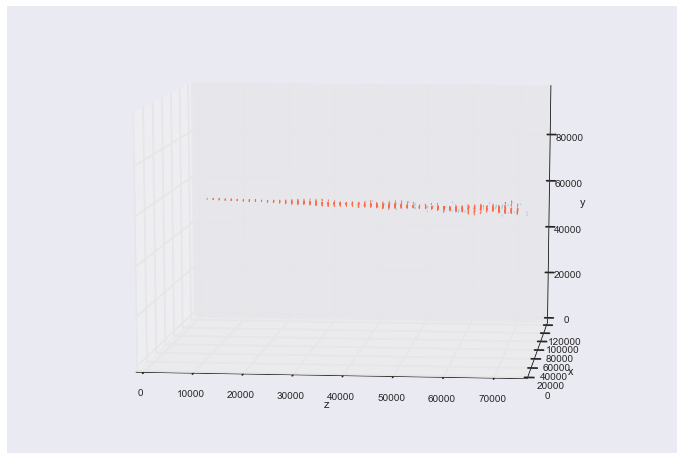

In [41]:
vis_data = dmix.loc[dmix['event'] == 4]
plot_bg_and_mc_2(vis_data.loc[vis_data['signal'] == 0], vis_data.loc[vis_data['signal'] == 1])

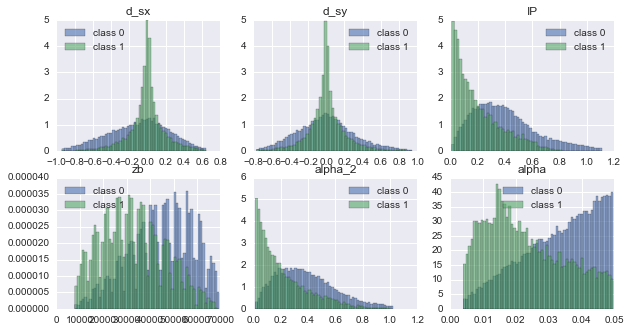

In [33]:
%matplotlib inline
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.6}

plt.figure(figsize=(10, 8))
for n, feature in enumerate(features):
    plt.subplot(len(features) // 2, 3, n+1)
    min_value, max_value = np.percentile(dmix[feature], [1, 99])
    plt.hist(dmix.ix[dmix.signal.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(dmix.ix[dmix.signal.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

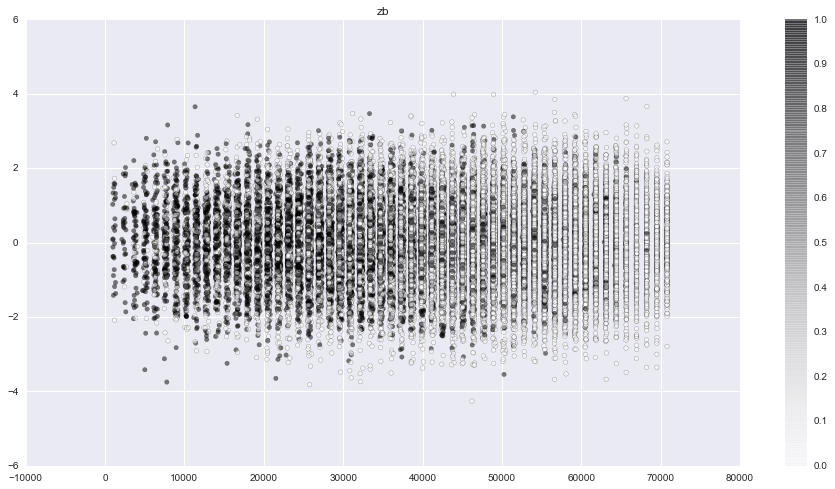

In [34]:
plt.figure(figsize=[16,8])

plt.title("zb")
plt.scatter(dmix.zb, np.random.normal(0,1,len(dmix.zb)) , c= dmix.signal,
            alpha = 0.5)

plt.colorbar()

In [35]:
len(dmix.loc[dmix['signal'] ==0]['b_x'])

42162

In [36]:
#train gbm and rf here
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

training_data, validation_data = train_test_split(dmix, random_state=11, train_size=0.9)
#randomForest = rf(n_estimators=500,max_depth=10)
#randomForest.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

In [37]:
from sklearn.ensemble import GradientBoostingClassifier as gbm
gradientBoosting = gbm(n_estimators = 200, max_depth = 5)
gradientBoosting.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [16]:
#from sklearn.svm import SVC
#svm_rbf = SVC(probability = True)
#svm_rbf.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
#rf_proba = randomForest.predict_proba(validation_data[features].astype(np.float64))
gbm_proba = gradientBoosting.predict_proba(validation_data[features].astype(np.float64))
#svm_rbf_proba = svm_rbf.predict_proba(validation_data[features].astype(np.float64))

In [39]:
#print roc_auc_score(validation_data.signal, rf_proba[:,1])
print roc_auc_score(validation_data.signal, gbm_proba[:,1])
#print roc_auc_score(validation_data.signal, svm_rbf_proba[:,1])

0.906682255828


In [40]:
from sklearn.metrics import accuracy_score
print accuracy_score(validation_data.signal, gbm_proba[:,1] > 0.5)

0.887996867045


#### IDEA: our observation are dependent as one set of tracks can be a trace of one particle. So we need to use this dependence. As we can't (can't?) recreate the track of particle through brick, we need to use another approach. If classifier gives a high probability to some track to be a signal we can use this track to create features for another tracks?

### What else we need to do:
#### We need to look how value of cone angle affect the classifier qualiity.

In [10]:
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier as gbm

fpr = dict()
tpr = dict()
models = dict()

for alpha in list([0.06, 0.075, 0.09]):
    dmix = combine_mc_bg(pmc, pbg, alpha)
    features = list(set(dmix.columns) - {'event', 'signal', 'b_x', 'b_y', 'b_z', 'b_sx', 'b_sy'})
    training_data, validation_data = train_test_split(dmix, random_state=11, train_size=0.9)
    
    gradientBoosting = gbm(n_estimators = 200, max_depth = 5)
    gradientBoosting.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))
    gbm_proba = gradientBoosting.predict_proba(validation_data[features].astype(np.float64))
    fpr[alpha], tpr[alpha], _ = roc_curve(validation_data.signal, gbm_proba[:,1])
    models["model{0}".format(alpha)] = gradientBoosting
    
    print str(alpha) + ": " + str(roc_auc_score(validation_data.signal, gbm_proba[:,1]))

0.06: 0.908246968885
0.075: 0.916071676248
0.09: 0.923669039164


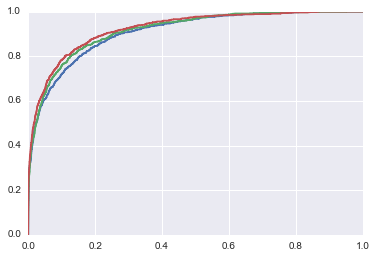

In [14]:
%matplotlib inline
for alpha in list([0.06, 0.075, 0.09]):
    plt.plot(fpr[alpha],tpr[alpha])
plt.show()

In [16]:
from sklearn.externals import joblib
joblib.dump(models['model0.06'], 'model06.pkl');
joblib.dump(models['model0.075'], 'model75.pkl');
joblib.dump(models['model0.09'], 'model9.pkl');

['model9.pkl',
 'model9.pkl_01.npy',
 'model9.pkl_02.npy',
 'model9.pkl_03.npy',
 'model9.pkl_04.npy',
 'model9.pkl_05.npy',
 'model9.pkl_06.npy',
 'model9.pkl_07.npy',
 'model9.pkl_08.npy',
 'model9.pkl_09.npy',
 'model9.pkl_10.npy',
 'model9.pkl_11.npy',
 'model9.pkl_12.npy',
 'model9.pkl_13.npy',
 'model9.pkl_14.npy',
 'model9.pkl_15.npy',
 'model9.pkl_16.npy',
 'model9.pkl_17.npy',
 'model9.pkl_18.npy',
 'model9.pkl_19.npy',
 'model9.pkl_20.npy',
 'model9.pkl_21.npy',
 'model9.pkl_22.npy',
 'model9.pkl_23.npy',
 'model9.pkl_24.npy',
 'model9.pkl_25.npy',
 'model9.pkl_26.npy',
 'model9.pkl_27.npy',
 'model9.pkl_28.npy',
 'model9.pkl_29.npy',
 'model9.pkl_30.npy',
 'model9.pkl_31.npy',
 'model9.pkl_32.npy',
 'model9.pkl_33.npy',
 'model9.pkl_34.npy',
 'model9.pkl_35.npy',
 'model9.pkl_36.npy',
 'model9.pkl_37.npy',
 'model9.pkl_38.npy',
 'model9.pkl_39.npy',
 'model9.pkl_40.npy',
 'model9.pkl_41.npy',
 'model9.pkl_42.npy',
 'model9.pkl_43.npy',
 'model9.pkl_44.npy',
 'model9.pkl_45.n

In [12]:
from sklearn.externals import joblib
gradientBoosting = joblib.load('model9.pkl') 

### Actually we can take a big enough angle to include all the signal in the analysis, It can help as to increase the quality of the classifier. Now we will make the GridSearch over the number of trees and max_deep

In [ ]:
from sklearn import grid_search
dmix.zb = dmix.zb + np.random.normal(0,3000,len(dmix.zb))
training_data, validation_data = train_test_split(dmix, random_state=11, train_size=0.9)
parameters = {'n_estimators':[100, 150, 200, 250, 300], 'max_depth':[4, 7, 10, 13, 20]}
GradientBoo sting = gbm()
clf = grid_search.GridSearchCV(GradientBoosting, parameters)
clf.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

## Now we will estimate the linear regression using the next equation

$$
Energy (Momentum) = a  + b N_{tracks}
$$

1. Build linear regression
2. Distribution of the error term

Как это сделать? Нужно взять события, которые не участвовали в обучении, добавить для них шум и запомнить их истинную энергию. После этого сделать предсказание, и оценить две модели.

In [9]:
events = combine_mc_bg(pmc, pbg, 0.09, begin = 50, end = 500) #450 ~ 1:30

In [10]:
event_id_set = set(events['event'])
features = list(set(events.columns) - {'event', 'signal', 'b_x', 'b_y', 'b_z', 'b_sx', 'b_sy'})

In [ ]:
features

In [78]:
x = []
y = []
for i in event_id_set:
    predict = events.loc[events['event'] == i, features]
    predict
    gbm_proba = gradientBoosting.predict_proba(predict.astype(np.float64))
    y.append(float(pmc.loc[pmc['Event_id'] == i, 'ele_P']))
    x.append(float(sum(gbm_proba[:,1] > 0.5)))

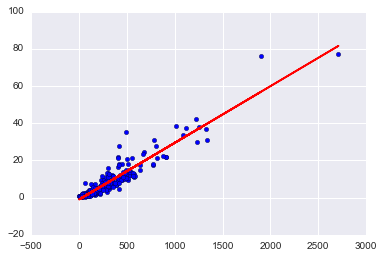

In [79]:
%matplotlib inline
x = np.array(x)
y = np.array(y)
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0]*x + fit[1], color='red')
ax.scatter(x, y)
fig.show()

In [80]:
print len(x)

316


In [81]:
print "intercept = " + str(fit[1])
print "beta = " + str(fit[0])

intercept = -0.990763441962
beta = 0.0304585813789


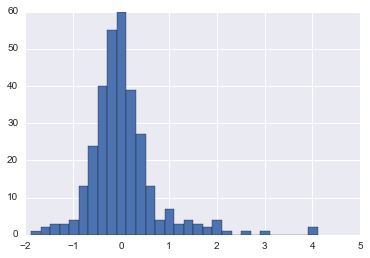

In [82]:
energy_resoultion = (y - fit[0] * x- fit[1])/y
plt.hist(energy_resoultion, bins = 30);

In [83]:
E_REC = fit[0] * x +  fit[1]

In [84]:
np.std(energy_resoultion)

0.70916482056732666

In [85]:
se = [[],[]]

In [86]:
true_and_rec = np.array([y, E_REC])

In [87]:
for i in range(8):
    tmp = true_and_rec[:,(E_REC < 2 * i + 2) & (E_REC >= 2*i) ]
    energy_res = np.std((tmp[0,:] - tmp[1,:])/tmp[0,:])
    print "Length of chunk: " + str(len(tmp[0,:]))
    se[0].append(energy_res)
    se[1].append(np.mean(tmp[1]))
fit_se = np.polyfit(1/np.sqrt(se[1]), se[0], deg=1)    

Length of chunk: 46
Length of chunk: 57
Length of chunk: 56
Length of chunk: 33
Length of chunk: 32
Length of chunk: 18
Length of chunk: 12
Length of chunk: 12


In [88]:
fit_se

array([ 0.2354174 ,  0.28414434])

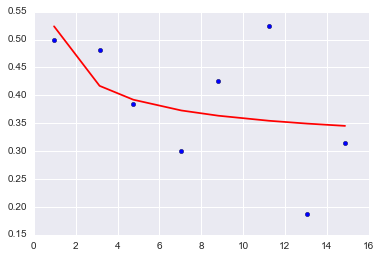

In [89]:
fig, ax = plt.subplots()
ax.plot(se[1], fit_se[0]/np.sqrt(se[1]) + fit_se[1], color='red')
ax.scatter(se[1], se[0])
fig.show()

Следующая цель -- построение алгоритма нахождения душа по первым пластинам кирпича.
Опишем, как будет рабоать наш алгоритм.

Основная идея будет заключаться в следующем. Возьмём 3 слоя кирпича. Запустим алгоритм на двух внешних слоях. Мы будем искать такие треки на внутреннем слое, которые лежат не далеко в заданном нами пространстве от тренков на внешних слоях.

После этого запустим алгоритм на внутреннем слое и удалим треки с внешних слоев.


Более подробно:
1. Возьмем первый трек на внутреннем слое. 
2. Найдем на двух внешних слоях похожие на трек.
3. Если таких нет, удалим его.
4. Если есть, перейдем дальше.
5. Запустим алгоритм на внешних слоях

Необходимо описать метрику, которая будет измерять похожесть треков. Понятно, что она должна включать в себя угол и расстояние. При этом, если угол слишком велик, то функция метрики должна становиться слишком большой. Аналогично с расстоянием. Можно начать со следующей простой функции.

$$
\rho(d_1, d_2) = C \cdot dist \cdot\tan (\alpha)
$$

Проблема может заключаться в том, что расстояние и тангенс имеют различные порядки. Вполне обоновановано будет поделить $dist$ на расстояние между пластинами, чтобы привезти его к значениями близким к единице.


$$
\rho(d_1, d_2) = C \cdot \frac{dist}{dZ} \cdot\tan (\alpha)
$$

После написания алгоритма, мы сможем увидеть недостатки данной метрики и исправить их.

ИДЕЯ: Вместо того, чтобы вручную подбирать метрику и параметры для неё, мы можем натренировать классификатор. Построим dataset в котором переменными будут: distance и angle. После этого пометим те наблюдения, которые были получены от одной и той же частицы, как сигнал. Остальные пометим как шум. Получив классификатор мы сможем успешно отвечать на вопрос: есть ли для данного трека продолжение на другой пластине.

In [82]:
def find_similar(track, data_to_clear):
    threshold = 0.15 # Best : 1
    for index, other in data_to_clear.iterrows():
        if (other[2] != track[2]): #b_z variable
            dist = distance(track, other)
            #print str(dist)
            if (dist < threshold):
                return True
            
    return False

def distance(track, other):
    distance = (track[0] - other[0])**2 + (track[1] - other[1])**2 + (track[2] - other[2])**2
    distance = distance**(0.5)
    angle = 1/(math.sqrt((track[3]-other[3])**2 + (track[4]-other[4])**2 + 1))
    rad_angle = math.acos(angle)
    tan_angle = math.tan(rad_angle)
    
    result = metrics(distance, tan_angle, 1)
    return result

def metrics(distance, tan_angle, C):
    result = distance/1293 * tan_angle * C
    return result

In [45]:
def find_shower(data, values_of_z):
    first_layer = data[data['s.eZ'] == values_of_z[0]]
    second_layer = data[data['s.eZ'] == values_of_z[1]]
    third_layer = data[data['s.eZ'] == values_of_z[2]]
    
    second_layer = clear_layer(second_layer, first_layer)
    second_layer = clear_layer(second_layer, third_layer)
    first_layer = clear_layer(first_layer, second_layer)
    third_layer = clear_layer(third_layer, second_layer)
    
    return pd.concat([first_layer, second_layer, third_layer])
            
def clear_layer(to_clear, to_compare):
    for index, track in to_clear.iterrows():
        result = find_similar(track, to_compare)
        if (result != True):
            to_clear = to_clear.drop(index)
            
    return to_clear

Протестируем алгортим. Возьмём произвольные пластины в качестве шума и положим на них сигнал, после этого посмотрим на количество выживших элементов сигнала и визуализируем оставшиеся треки.

In [83]:
data_to_clear = pbg[pbg['s.eZ'].isin([69822, 71115, 68529])]
data_to_clear['signal'] = 0
data_to_clear = data_to_clear.apply(np.random.permutation)
data_to_clear = data_to_clear[:1000]

/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [84]:
accuracy = []
for i in range(10):
    
    my_shower = pmc.iloc[i]
    
    shower_frame = pd.DataFrame([
                my_shower['BT_X'],
                my_shower['BT_Y'],
                my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
                my_shower['BT_SX'],
                my_shower['BT_SY']],
                index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
    shower_frame['signal'] = 1
    shower_frame['s.eChi2'] = 0
    
    shower_frame = shower_frame[shower_frame['s.eZ'].isin([69822, 71115, 68529])]
    testing_data = pd.concat([shower_frame, data_to_clear])
    cleared_data = find_shower(testing_data, [69822, 71115, 68529])
    accuracy.append(float(sum(cleared_data.signal == 1))/float(len(shower_frame)))
    print "Signal in the data: " + str(len(shower_frame))
    print "Founded signal: " + str(sum(cleared_data.signal == 1))
    print "Share of oroginal signal: " + str(float(sum(cleared_data.signal == 1))/float(len(shower_frame)))
    print "Noise marked as signal: " + str(sum(cleared_data.signal == 0))
    print '\n'
    

Signal in the data: 19
Founded signal: 6
Share of oroginal signal: 0.315789473684
Noise marked as signal: 6


Signal in the data: 34
Founded signal: 23
Share of oroginal signal: 0.676470588235
Noise marked as signal: 6


Signal in the data: 10
Founded signal: 0
Share of oroginal signal: 0.0
Noise marked as signal: 6


Signal in the data: 3
Founded signal: 3
Share of oroginal signal: 1.0
Noise marked as signal: 6


Signal in the data: 86
Founded signal: 52
Share of oroginal signal: 0.604651162791
Noise marked as signal: 6


Signal in the data: 3
Founded signal: 0
Share of oroginal signal: 0.0
Noise marked as signal: 6


Signal in the data: 19
Founded signal: 5
Share of oroginal signal: 0.263157894737
Noise marked as signal: 6


Signal in the data: 3
Founded signal: 0
Share of oroginal signal: 0.0
Noise marked as signal: 6


Signal in the data: 4
Founded signal: 0
Share of oroginal signal: 0.0
Noise marked as signal: 6


Signal in the data: 25
Founded signal: 8
Share of oroginal signal: 

Модификация алгоритма, которая может одновременно работать со слоями количеством больше 3:

In [33]:
def complete_shower_finder(data):
    layers = list(set(data['s.eZ']))
    layers.sort()
    for i in range(len(layers) - 2):
        data_to_clear = data[data['s.eZ'].isin(layers[i: i + 3])]
        cleared_data = find_shower(data_to_clear, layers[i: i + 3])
        data = data.drop(data.index[data['s.eZ'].isin(layers[i: i + 3])])
        data = pd.concat([data, cleared_data])
        
    # repeat again for the first layers
    data_to_clear = data[data['s.eZ'].isin(layers[0: 3])]
    cleared_data = find_shower(data_to_clear, layers[0: 3])
    data = data.drop(data.index[data['s.eZ'].isin(layers[0: 3])])
    data = pd.concat([data, cleared_data])
    return data

Протестируем итоговый алгоритм на нахождение душа в 10 слоях и сравним с его работой при отстутствии сигнала в данных.

In [88]:
z_coordinates = list(set(pbg['s.eZ']))
z_coordinates.sort()
def f(x): return x > 60000
z_coordinates = filter(f, z_coordinates)

In [89]:
data_to_clear = pbg[pbg['s.eZ'].isin(z_coordinates)]
data_to_clear = data_to_clear.apply(np.random.permutation)

In [90]:
data_to_clear['signal'] = 0

In [91]:
data_to_clear = data_to_clear[:10000]

In [92]:
my_shower = pmc.iloc[4]
shower_frame = pd.DataFrame([
                my_shower['BT_X'],
                my_shower['BT_Y'],
                my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
                my_shower['BT_SX'],
                my_shower['BT_SY']],
                index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
shower_frame['signal'] = 1
shower_frame['s.eChi2'] = 0
    
shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]
print len(shower_frame)
testing_data = pd.concat([shower_frame, data_to_clear])

235


In [93]:
cleared_data = complete_shower_finder(testing_data)

len(slopes): 128


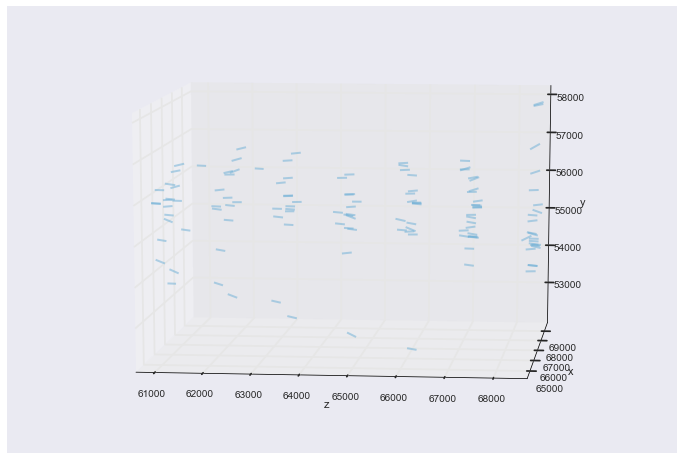

In [94]:
%matplotlib inline
plot_bg(cleared_data)

len(slopes): 235


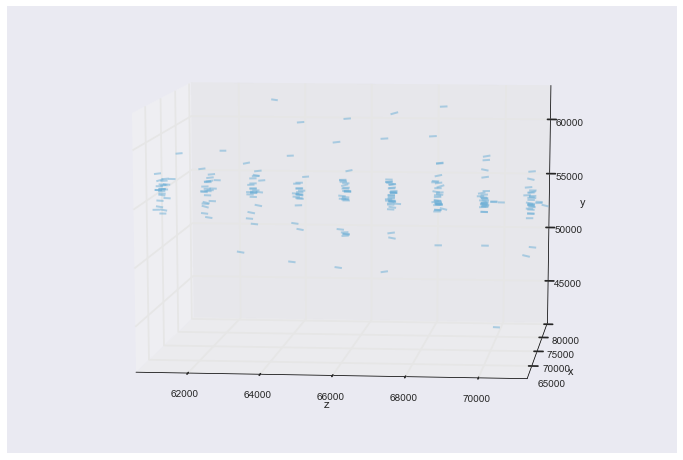

In [95]:
plot_bg(shower_frame)

In [96]:
sum(cleared_data.signal == 1)

128

len(slopes): 10235


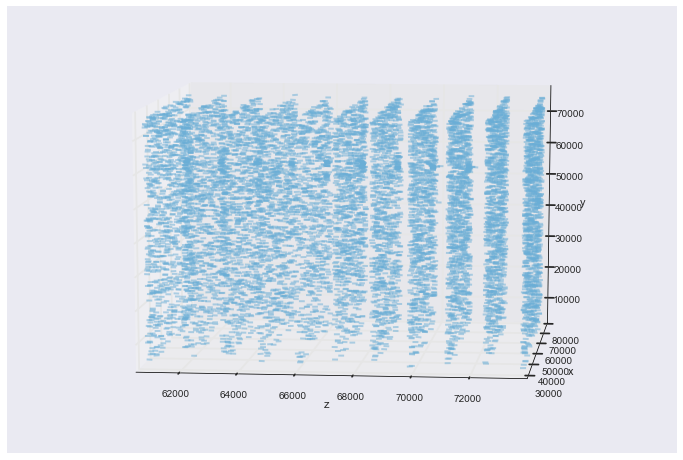

In [97]:
plot_bg(testing_data)